## Historical Wildfire Analysis on or Near Tribal Lands
Lilly Jones, PhD

This notebook analyzes historical wildfire data, focusing on fires occurring **on or near Tribal lands** in the United States.

## Objectives
- Load and process historical wildfire data
- Identify fires on or near Tribal lands
- Analyze **temporal** and **spatial** patterns
- Visualize fire **frequency**, **severity**, and **trends**

## Data Sources
- **MTBS (Monitoring Trends in Burn Severity)**: Historical fire perimeters
- **NIFC (National Interagency Fire Center)**: Fire occurrence data
- **US Census Bureau**: Tribal lands boundaries (TIGER/Line)
- **BIA (Bureau of Indian Affairs)**: Tribal lands datasets

In [1]:
# Install required packages (uncomment if needed)
# !pip install geopandas pandas matplotlib seaborn folium requests shapely pyproj contextily

In [2]:
# Import libraries

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from pathlib import Path
import numpy as np
from datetime import datetime
from shapely.geometry import Point, box
import warnings
import requests
from io import BytesIO
import zipfile
import os
import contextily as ctx

warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

Libraries imported successfully.


In [3]:
# Create paths

# Get the current working directory (where Python is running) then move one level up in the directory tree
ROOT = Path.cwd().parent

# Create a Path object pointing to your project’s data/directory
DATA = ROOT/"data" 

# Create a Path object pointing to your project’s output/directory. 
OUTPUT = ROOT/"output"

# Create directories if they don't exist
DATA.mkdir(parents=True, exist_ok=True)
OUTPUT.mkdir(parents=True, exist_ok=True)

TRIBAL_LANDS_DIR = DATA / "tribal_lands"
FIRES_DIR = DATA / "fires"

TRIBAL_LANDS_DIR.mkdir(parents=True, exist_ok=True)
FIRES_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
def download_tribal_lands(data_dir=TRIBAL_LANDS_DIR):
    """
    Download tribal lands boundaries from US Census Bureau TIGER/Line files
    American Indian/Alaska Native/Native Hawaiian Areas (AIANNH)
    Change url as needed - this one calls the 2023 AIANNH dataset
    """

    url = "https://www2.census.gov/geo/tiger/TIGER2023/AIANNH/tl_2023_us_aiannh.zip"
    shp_path = data_dir / "tl_2023_us_aiannh.shp"

    # Skip download if already exists
    if shp_path.exists():
        print("Tribal lands data already exists — loading from disk.")
        return gpd.read_file(shp_path)

    print("Downloading tribal lands data...")

    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()

        with zipfile.ZipFile(BytesIO(response.content)) as z:
            z.extractall(data_dir)

        tribal_gdf = gpd.read_file(shp_path)
        print(f"Successfully loaded {len(tribal_gdf)} tribal land areas")
        return tribal_gdf

    except Exception as e:
        print(f"Error downloading tribal lands: {e}")
        print("Manual download: https://www.census.gov/cgi-bin/geo/shapefiles/index.php")
        return None

In [5]:
# Call the function
tribal_lands = download_tribal_lands()

Tribal lands data already exists — loading from disk.


In [6]:
# Check the tribal lands data
if tribal_lands is not None:
    print("Tribal Lands Data Overview:")
    print(tribal_lands.head())
    print(f"\nTotal tribal areas: {len(tribal_lands)}")
    print(f"\nColumns: {tribal_lands.columns.tolist()}")

Tribal Lands Data Overview:
  AIANNHCE  AIANNHNS  GEOID         GEOIDFQ                    NAME  \
0     2320  02419022  2320R  2520000US2320R                 Mohegan   
1     9100  01930930  9100R  2520000US9100R  Golden Hill Paugussett   
2     4110  02419484  4110R  2520000US4110R          Table Mountain   
3     1380  01666180  1380R  2520000US1380R              Greenville   
4     1110  00806894  1110R  2520000US1110R                Flathead   

                                     NAMELSAD LSAD CLASSFP COMPTYP AIANNHR  \
0                         Mohegan Reservation   86      D2       R       F   
1  Golden Hill Paugussett (state) Reservation   86      D4       R       S   
2                    Table Mountain Rancheria   85      D8       R       F   
3                        Greenville Rancheria   85      D2       R       F   
4                        Flathead Reservation   86      D2       R       F   

   MTFCC FUNCSTAT       ALAND     AWATER     INTPTLAT      INTPTLON  \
0  G2

### Load or Download Fire Data
**Note:** Fire datasets can be large. You have several options:
- Use the sample data provided below  
- Download from NIFC: https://data-nifc.opendata.arcgis.com/  
- Download from MTBS: https://www.mtbs.gov/direct-download  
- Use your own fire occurrence data

In [7]:
# Obtain fire perimeter data from MTBS
def load_mtbs_fire_perimeters(mtbs_path):
    """
    Load MTBS fire perimeter data (shapefile or geopackage)

    Expected MTBS fields typically include:
    - Incid_Name
    - Ig_Date
    - BurnBndAc
    - geometry

    Adjust column names as needed based on your MTBS version.
    """
    mtbs_path = Path(mtbs_path)
    print(f"Loading MTBS fire perimeters from {mtbs_path}...")

    gdf = gpd.read_file(mtbs_path)

    # Normalize column names
    gdf.columns = gdf.columns.str.lower()

    # Parse ignition date if present
    if "ig_date" in gdf.columns:
        gdf["fire_year"] = pd.to_datetime(gdf["ig_date"]).dt.year

    # Standardize acreage
    if "burnbndac" in gdf.columns:
        gdf["fire_size_acres"] = gdf["burnbndac"]

    # Create fire id if missing
    if "fire_id" not in gdf.columns:
        gdf["fire_id"] = gdf.index.astype(str)

    # Optional: simplify to key columns
    keep_cols = [
        "fire_id",
        "incid_name",
        "fire_year",
        "fire_size_acres",
        "geometry"
    ]

    gdf = gdf[[c for c in keep_cols if c in gdf.columns]]

    print(f"Loaded {len(gdf)} MTBS fire perimeters")

    return gdf

In [8]:
# Load MTBS data
mtbs_path = "C:\Miniconda\datasets\mtbs_perimeter_data\mtbs_perims_DD.shp"
fire_data = load_mtbs_fire_perimeters(mtbs_path)
fire_data.head()

Loading MTBS fire perimeters from C:\Miniconda\datasets\mtbs_perimeter_data\mtbs_perims_DD.shp...
Loaded 30730 MTBS fire perimeters


,fire_id,incid_name,fire_year,fire_size_acres,geometry
0,0,CAMELBACK,1985,4780,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,1,SUGARLOAF,1985,5489,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,2,TAL NW 44,1985,1491,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,3,GAL NE 48,1985,1298,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,4,UNNAMED,1985,1326,"POLYGON ((-110.67330 31.75345, -110.67378 31.7..."


In [9]:
# Add size classes
fire_data["size_class"] = pd.cut(
    fire_data["fire_size_acres"],
    bins=[0, 10, 100, 300, 1000, 5000, float("inf")],
    labels=["A", "B", "C", "D", "E", "F"]
)

In [10]:
# Path to the MTBS shapefile (relative path)
# mtbs_path = os.path.join("data", "mtbs_perims_DD.shp")

# Check that the file exists
if not os.path.exists(mtbs_path):
    raise FileNotFoundError(
        f"MTBS shapefile not found at {mtbs_path}. "
        "Please download it and place it in the 'data/' folder."
    )

# Load the shapefile into a GeoDataFrame
fire_gdf = gpd.read_file(mtbs_path)

# Optional: check the first few rows
print(fire_gdf.head())

# Check the geometry type and CRS
print(f"Geometry type: {fire_gdf.geom_type.unique()}")
print(f"CRS: {fire_gdf.crs}")


                Event_ID irwinID Incid_Name Incid_Type  Map_ID Map_Prog  \
0  AK6260315742119850801    None  CAMELBACK   Wildfire    4737     MTBS   
1  AK6256215664519850720    None  SUGARLOAF   Wildfire    4738     MTBS   
2  AK6547615382919850801    None  TAL NW 44   Wildfire    4739     MTBS   
3  AK6521015526519850803    None  GAL NE 48   Wildfire    4740     MTBS   
4  AZ3178311066219850302    None    UNNAMED   Wildfire    4741     MTBS   

  Asmnt_Type  BurnBndAc BurnBndLat BurnBndLon  ... Perim_ID dNBR_offst  \
0   Extended       4780     62.603   -157.421  ...     None         27   
1   Extended       5489     62.562   -156.645  ...     None          3   
2   Extended       1491     65.476   -153.829  ...     None         14   
3   Extended       1298     65.210   -155.265  ...     None         14   
4    Initial       1326     31.783   -110.662  ...     None        -10   

  dNBR_stdDv NoData_T  IncGreen_T  Low_T  Mod_T  High_T  \
0      -9999     -970        -150    130    3

In [11]:
# Identify fires on or near Tribal Lands

def identify_fires_near_tribal_lands(fire_gdf, tribal_gdf, buffer_distance_km=5):
    """
    Identify fires that occurred on or near tribal lands
    
    Parameters:
    - fire_gdf: GeoDataFrame of fire locations
    - tribal_gdf: GeoDataFrame of tribal land boundaries
    - buffer_distance_km: Distance in km to consider as "near"
    """
    print("Identifying fires on or near tribal lands...")
    
    # Ensure both GeoDataFrames use the same CRS
    if fire_gdf.crs != tribal_gdf.crs:
        tribal_gdf = tribal_gdf.to_crs(fire_gdf.crs)
    
    # Project to a meters-based CRS for accurate buffering (using UTM zone 12N as example)
    
    # Adjust based on your study area
    fire_projected = fire_gdf.to_crs('EPSG:3857')  # Web Mercator
    tribal_projected = tribal_gdf.to_crs('EPSG:3857')
    
    # Create buffer around tribal lands (convert km to meters)
    buffer_meters = buffer_distance_km * 1000
    tribal_buffered = tribal_projected.copy()
    tribal_buffered['geometry'] = tribal_projected.buffer(buffer_meters)
    
    # Spatial join: find fires within buffered tribal lands
    fires_near_tribal = gpd.sjoin(
        fire_projected,
        tribal_buffered,
        how='inner',
        predicate='within'
    )
    
    # Convert back to original CRS
    fires_near_tribal = fires_near_tribal.to_crs('EPSG:4326')
    
    # Also identify fires directly ON tribal lands (no buffer)
    fires_on_tribal = gpd.sjoin(
        fire_projected,
        tribal_projected,
        how='inner',
        predicate='within'
    ).to_crs('EPSG:4326')
    
    print(f"Found {len(fires_on_tribal)} fires ON tribal lands")
    print(f"Found {len(fires_near_tribal)} fires within {buffer_distance_km}km of tribal lands")
    
    return fires_on_tribal, fires_near_tribal

# Perform spatial analysis
if tribal_lands is not None:
    fires_on_tribal, fires_near_tribal = identify_fires_near_tribal_lands(
        fire_gdf, 
        tribal_lands, 
        buffer_distance_km=5
    )
else:
    print("Tribal lands data not available. Skipping spatial analysis.")

Identifying fires on or near tribal lands...
Found 1538 fires ON tribal lands
Found 2121 fires within 5km of tribal lands


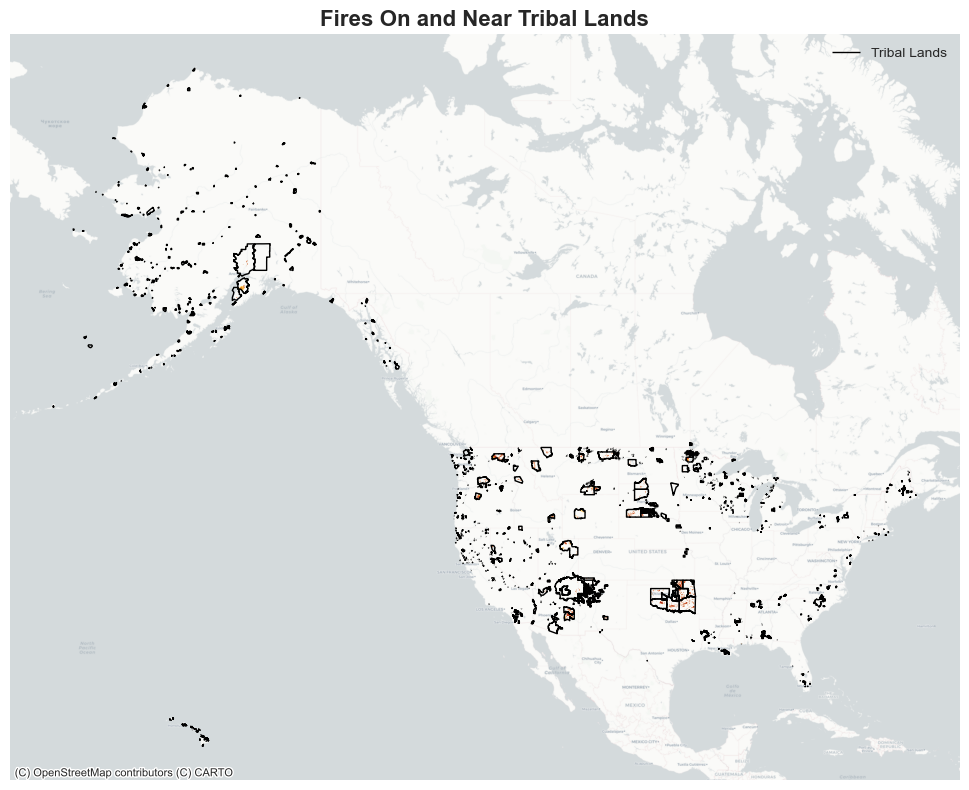

In [ ]:
# Visualize map

def plot_fires_on_near_tribal(fires_on_tribal, fires_near_tribal, tribal_gdf):
    """
    Plot fires on and near tribal lands with basemap.
    """
    # Reproject everything to Web Mercator for basemap compatibility
    fires_on = fires_on_tribal.to_crs(epsg=3857)
    fires_near = fires_near_tribal.to_crs(epsg=3857)
    tribal = tribal_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot Tribal lands
    tribal.boundary.plot(ax=ax, linewidth=1, color="black", label="Tribal Lands")
    
    # Fires near tribal lands
    if not fires_near.empty:
        fires_near.plot(
            ax=ax,
            color="orange",
            markersize=20,
            alpha=0.7,
            label="Fires Near Tribal Lands"
        )
    
    # Fires on tribal lands
    if not fires_on.empty:
        fires_on.plot(
            ax=ax,
            color="firebrick",
            markersize=30,
            alpha=0.8,
            label="Fires On Tribal Lands"
        )

    # Add basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        zoom=5
    )

    ax.set_title("Fires On and Near Tribal Lands", fontsize=16, fontweight="bold")
    ax.set_axis_off()
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig

# Example usage:
if tribal_lands is not None:
    fig = plot_fires_on_near_tribal(fires_on_tribal, fires_near_tribal, tribal_lands)


In [ ]:
# Save this map to cwd
plt.savefig("fires_on_near_tribal_lands.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [14]:
print(os.getcwd())
#TODO FIX THIS!!


c:\Miniconda\Tribal_fire_science\notebooks


In [15]:
# Convert ignition data (Ig_Date) to datetime

fires_on_tribal["Ig_Date"] = pd.to_datetime(fires_on_tribal["Ig_Date"], errors="coerce")
fires_on_tribal["fire_year"] = fires_on_tribal["Ig_Date"].dt.year

# Check your dataframe
fires_on_tribal[["Ig_Date", "fire_year"]].head()

,Ig_Date,fire_year
5,1985-03-25,1985
6,1985-04-14,1985
7,1985-07-03,1985
8,1985-07-03,1985
9,1985-07-05,1985


In [16]:
# Convert Ig_Date to datetime and extract year for NEAR fires
fires_near_tribal = fires_near_tribal.copy()
fires_near_tribal["Ig_Date"] = pd.to_datetime(fires_near_tribal["Ig_Date"], errors="coerce")
fires_near_tribal["fire_year"] = fires_near_tribal["Ig_Date"].dt.year

# Quick check
fires_near_tribal[["Ig_Date", "fire_year"]].head()

,Ig_Date,fire_year
5,1985-03-25,1985
6,1985-04-14,1985
7,1985-07-03,1985
8,1985-07-03,1985
9,1985-07-05,1985


In [17]:
# Count fires per year
fires_on_per_year = fires_on_tribal.groupby("fire_year").size()
fires_on_per_year

fire_year
1984     9
1985    21
1986     1
1987    12
1988    28
1989    15
1990     6
1991    21
1992    20
1993    10
1994    31
1995    26
1996    40
1997    10
1998    37
1999    38
2000    47
2001    23
2002    26
2003    30
2004    37
2005    91
2006    81
2007    40
2008    47
2009    54
2010    39
2011    86
2012    62
2013    22
2014    39
2015    41
2016    66
2017    65
2018    47
2019    28
2020    42
2021    53
2022    70
2023    35
2024    42
dtype: int64

In [18]:
# Calculate acres burned per year

acres_on_per_year = fires_on_tribal.groupby("fire_year")["BurnBndAc"].sum()
acres_on_per_year

fire_year
1984     22218
1985     92347
1986      3714
1987     46606
1988    111709
1989     32072
1990     26134
1991    117015
1992     53508
1993     39505
1994    176444
1995     70107
1996    161103
1997     23639
1998    133540
1999    105437
2000    181449
2001    130347
2002    105547
2003    128431
2004    138453
2005    335521
2006    231232
2007    166856
2008    147263
2009    309292
2010     75617
2011    372827
2012    399797
2013     73062
2014    326925
2015    259737
2016    279262
2017    240982
2018    203474
2019    131727
2020    359911
2021    337526
2022    233112
2023    152109
2024    135954
Name: BurnBndAc, dtype: int64

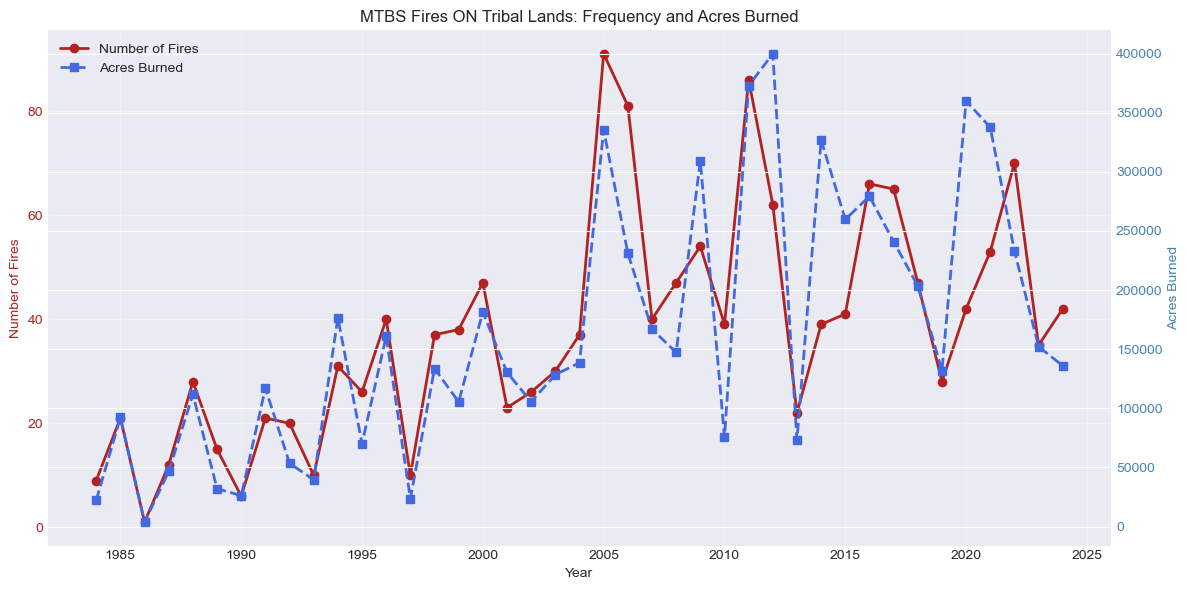

In [19]:
# Plot results

fig, ax1 = plt.subplots(figsize=(12, 6))

# Number of fires (left axis)
ax1.plot(
    fires_on_per_year.index,
    fires_on_per_year.values,
    marker='o',
    linewidth=2,
    color="firebrick",
    label="Number of Fires"
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Fires", color="firebrick")
ax1.tick_params(axis='y', labelcolor="firebrick")
ax1.grid(alpha=0.3)

# Second axis for acres burned
ax2 = ax1.twinx()

ax2.plot(
    acres_on_per_year.index,
    acres_on_per_year.values,
    marker='s',
    linestyle='--',
    linewidth=2,
    color="royalblue",
    label="Acres Burned"
)

ax2.set_ylabel("Acres Burned", color="steelblue")
ax2.tick_params(axis='y', labelcolor="steelblue")

# Title
plt.title("MTBS Fires ON Tribal Lands: Frequency and Acres Burned")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


In [20]:
def generate_fire_statistics_mtbs(fire_gdf, label="MTBS Fires", return_df=False):
    """
    Generate statistics for MTBS fire perimeter GeoDataFrames
    """
    fire_gdf = fire_gdf.copy()
    fire_gdf["fire_year"] = pd.to_datetime(fire_gdf["Ig_Date"]).dt.year

    print(f"\n{'='*60}")
    print(f"FIRE STATISTICS: {label}")
    print(f"{'='*60}\n")
    
    # Basic stats
    total_fires = len(fire_gdf)
    date_range = (fire_gdf['fire_year'].min(), fire_gdf['fire_year'].max())
    total_acres = fire_gdf['BurnBndAc'].sum()
    avg_size = fire_gdf['BurnBndAc'].mean()
    median_size = fire_gdf['BurnBndAc'].median()
    largest_fire = fire_gdf['BurnBndAc'].max()
    
    print(f"Total fires: {total_fires:,}")
    print(f"Date range: {date_range[0]} - {date_range[1]}")
    print(f"Total acres burned: {total_acres:,.0f}")
    print(f"Average fire size: {avg_size:,.1f} acres")
    print(f"Median fire size: {median_size:,.1f} acres")
    print(f"Largest fire: {largest_fire:,.0f} acres")

    # Fires per year
    fires_per_year = fire_gdf.groupby("fire_year").size()
    print(f"Average fires per year: {fires_per_year.mean():.1f}")

    # Top 10 tribes
    if "NAME" in fire_gdf.columns:
        tribe_counts = fire_gdf["NAME"].value_counts().head(10)
        print("\nTop 10 Tribal Lands by fire count:")
        for tribe, count in tribe_counts.items():
            pct = (count / total_fires) * 100
            print(f"  {tribe}: {count:,} ({pct:.1f}%)")
    
    if return_df:
        return {
            "fires_per_year": fires_per_year,
            "tribe_counts": tribe_counts if "NAME" in fire_gdf.columns else None
        }


In [21]:
# Calculate acres burned per Tribe

def acres_burned_per_tribe(fire_gdf):
    if "NAME" not in fire_gdf.columns:
        print("No tribal names found.")
        return None
    
    acres_per_tribe = fire_gdf.groupby("NAME")["BurnBndAc"].sum().sort_values(ascending=False)
    print("\nTop 10 Tribes by total acres burned:")
    print(acres_per_tribe.head(10))
    return acres_per_tribe

In [22]:
# Plot trends

def plot_trends_on_near(fires_on, fires_near):
    # Fire counts per year
    fires_on_year = fires_on.groupby(fires_on["fire_year"]).size()
    fires_near_year = fires_near.groupby(fires_near["fire_year"]).size()

    # Acres burned per year
    acres_on_year = fires_on.groupby("fire_year")["BurnBndAc"].sum()
    acres_near_year = fires_near.groupby("fire_year")["BurnBndAc"].sum()

    fig, ax1 = plt.subplots(figsize=(12,6))

    # Plot fire counts
    ax1.plot(fires_on_year.index, fires_on_year.values, marker='o', color='firebrick', label="Fires ON")
    ax1.plot(fires_near_year.index, fires_near_year.values, marker='o', color='orange', label="Fires NEAR")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Number of Fires")
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(alpha=0.3)

    # Acres burned
    ax2 = ax1.twinx()
    ax2.plot(acres_on_year.index, acres_on_year.values, linestyle='--', marker='s', color='darkred', label="Acres ON")
    ax2.plot(acres_near_year.index, acres_near_year.values, linestyle='--', marker='s', color='darkorange', label="Acres NEAR")
    ax2.set_ylabel("Acres Burned")
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.title("MTBS Fires ON vs NEAR Tribal Lands")
    plt.tight_layout()
    plt.show()


In [23]:
# Look for largest fires

def largest_fires(fire_gdf, n=10):
    top_fires = fire_gdf.sort_values("BurnBndAc", ascending=False).head(n)
    print(f"\nTop {n} largest fires:")
    print(top_fires[["Event_ID", "Incid_Name", "BurnBndAc", "fire_year", "NAME"]])
    return top_fires

In [24]:
# Plot acres by Tribe

def plot_acres_by_tribe(fire_gdf, top_n=10):
    acres = fire_gdf.groupby("NAME")["BurnBndAc"].sum().sort_values(ascending=False).head(top_n)
    acres.plot(kind="bar", figsize=(12,6), color="forestgreen", alpha=0.8)
    plt.ylabel("Acres Burned")
    plt.title(f"Top {top_n} Tribes by Acres Burned")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [25]:
def export_fire_stats(fire_gdf, filename="fire_stats.csv"):
    """
    Export selected MTBS fire attributes to CSV
    """
    fire_gdf[["Event_ID", "Incid_Name", "Ig_Date", "fire_year", "BurnBndAc", "NAME"]].to_csv(filename, index=False)
    print(f"Stats exported to {filename}")


FIRE STATISTICS: Fires ON Tribal Lands

Total fires: 1,538
Date range: 1984 - 2024
Total acres burned: 6,671,511
Average fire size: 4,337.8 acres
Median fire size: 2,262.5 acres
Largest fire: 106,432 acres
Average fires per year: 37.5

Top 10 Tribal Lands by fire count:
  Choctaw: 195 (12.7%)
  Osage: 153 (9.9%)
  Creek: 115 (7.5%)
  San Carlos: 81 (5.3%)
  Kiowa-Comanche-Apache-Fort Sill Apache: 79 (5.1%)
  Cherokee: 78 (5.1%)
  Fort Apache: 76 (4.9%)
  Chickasaw: 69 (4.5%)
  Colville: 63 (4.1%)
  Pine Ridge: 53 (3.4%)

FIRE STATISTICS: Fires NEAR Tribal Lands

Total fires: 2,121
Date range: 1984 - 2024
Total acres burned: 9,952,687
Average fire size: 4,692.5 acres
Median fire size: 2,160.0 acres
Largest fire: 193,798 acres
Average fires per year: 51.7

Top 10 Tribal Lands by fire count:
  Choctaw: 202 (9.5%)
  Osage: 172 (8.1%)
  Creek: 118 (5.6%)
  San Carlos: 101 (4.8%)
  Fort Apache: 100 (4.7%)
  Cherokee: 92 (4.3%)
  Kiowa-Comanche-Apache-Fort Sill Apache: 82 (3.9%)
  Chickasaw:

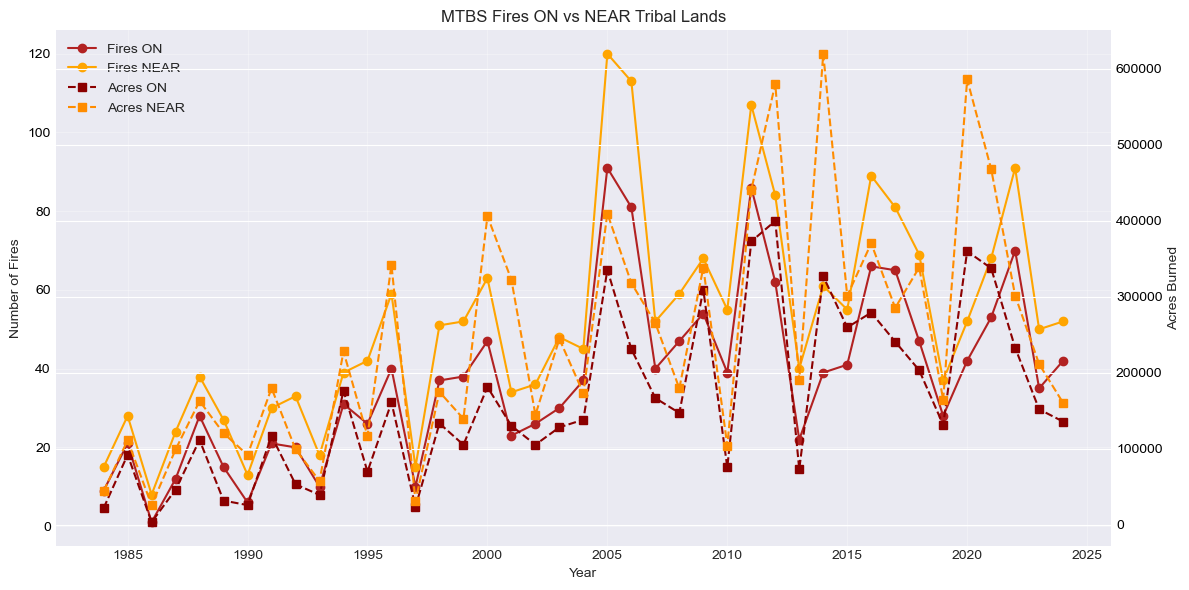


Top 10 largest fires:
                    Event_ID      Incid_Name  BurnBndAc  fire_year  \
20006  UT4060611070920200821       EAST FORK     106432       2020   
24993  AZ3341710997520140419           SKUNK      73774       2014   
23984  OR4483012137720150812   COUNTY LINE 2      68189       2015   
9424   MT4550810679219940908       BABY DEAN      61955       1994   
19209  WA4815011930020210804        WHITMORE      59925       2021   
26341  OK3595609643920120803    FREEDOM HILL      57116       2012   
15543  OK3431309744020090409   LOCO-HEALDTON      56584       2009   
18687  WA4828511853120210713    SUMMIT TRAIL      54855       2021   
24940  OK3681409579220140223         UNNAMED      51112       2014   
20512  WA4793911861820190802  WILLIAMS FLATS      44680       2019   

                    NAME  
20006   Uintah and Ouray  
24993         San Carlos  
23984       Warm Springs  
9424   Northern Cheyenne  
19209           Colville  
26341              Creek  
15543          Ch

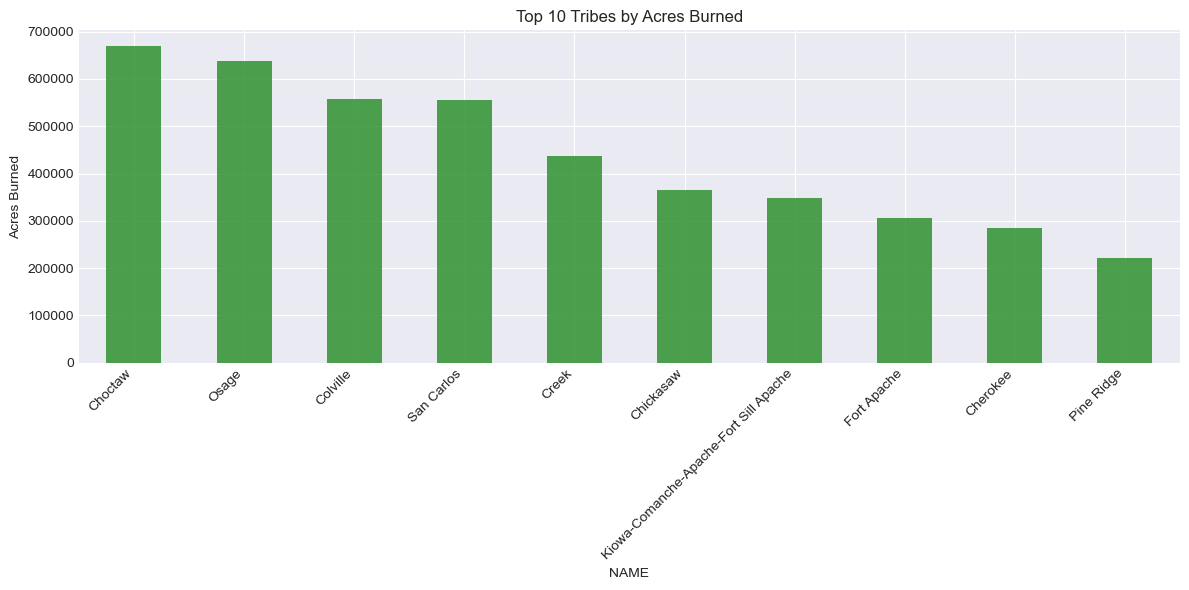

In [26]:
# Call the functions

# Stats
generate_fire_statistics_mtbs(fires_on_tribal, "Fires ON Tribal Lands")
generate_fire_statistics_mtbs(fires_near_tribal, "Fires NEAR Tribal Lands")

# Acres per tribe
acres_burned_per_tribe(fires_on_tribal)

# Trends
plot_trends_on_near(fires_on_tribal, fires_near_tribal)

# Largest fires
largest_fires(fires_on_tribal, n=10)

# Export CSV
export_fire_stats(fires_on_tribal, filename="fires_on_tribal_stats.csv")

# Bar chart by tribe
plot_acres_by_tribe(fires_on_tribal, top_n=10)


In [27]:
def analyze_fire_risk_by_tribal_land(fires_on_tribal, tribal_gdf):
    """
    Analyze fire risk metrics for each tribal land using MTBS data.

    Parameters:
    - fires_on_tribal: GeoDataFrame of fires on tribal lands
    - tribal_gdf: GeoDataFrame of tribal land boundaries (used for name reference)
    
    Returns:
    - DataFrame with fire risk statistics per tribal land
    """
    if len(fires_on_tribal) == 0:
        print("No fires on tribal lands to analyze")
        return None

    # Ensure fire_year exists
    if "fire_year" not in fires_on_tribal.columns:
        fires_on_tribal["fire_year"] = pd.to_datetime(fires_on_tribal["Ig_Date"], errors="coerce").dt.year

    # Group by tribal land name
    tribal_fire_stats = fires_on_tribal.groupby('NAME').agg({
        'Event_ID': 'count',           # Number of fires
        'BurnBndAc': ['sum', 'mean', 'max'],  # Acres burned
        'fire_year': ['min', 'max']           # First and last fire year
    }).reset_index()

    # Flatten column names
    tribal_fire_stats.columns = [
        'tribal_land', 
        'fire_count', 
        'total_acres', 
        'avg_fire_size', 
        'max_fire_size', 
        'first_fire_year', 
        'last_fire_year'
    ]

    # Calculate average acres burned per year
    tribal_fire_stats['avg_acres_per_year'] = tribal_fire_stats['total_acres'] / (
        tribal_fire_stats['last_fire_year'] - tribal_fire_stats['first_fire_year'] + 1
    )

    # Calculate fires per decade
    tribal_fire_stats['fires_per_decade'] = tribal_fire_stats['fire_count'] / (
        (tribal_fire_stats['last_fire_year'] - tribal_fire_stats['first_fire_year'] + 1) / 10
    )

    # Normalize risk score: frequency * avg fire size
    tribal_fire_stats['risk_score'] = tribal_fire_stats['fires_per_decade'] * tribal_fire_stats['avg_fire_size']

    # Sort by risk score descending
    tribal_fire_stats = tribal_fire_stats.sort_values('risk_score', ascending=False)

    # Display top 20 tribal lands by risk
    print("\nTop 20 Tribal Lands by Fire Risk:")
    print("="*80)
    print(tribal_fire_stats.head(20).to_string(index=False))

    return tribal_fire_stats

In [28]:
# Call the function

if tribal_lands is not None and len(fires_on_tribal) > 0:
    tribal_risk_stats = analyze_fire_risk_by_tribal_land(fires_on_tribal, tribal_lands)


Top 20 Tribal Lands by Fire Risk:
                           tribal_land  fire_count  total_acres  avg_fire_size  max_fire_size  first_fire_year  last_fire_year  avg_acres_per_year  fires_per_decade    risk_score
                                 Osage         153       638179    4171.104575          32901             1994            2024        20586.419355         49.354839 205864.193548
                               Choctaw         195       669243    3432.015385          17973             1991            2024        19683.617647         57.352941 196836.176471
                            San Carlos          81       554726    6848.469136          73774             1987            2024        14598.052632         21.315789 145980.526316
                              Colville          63       557949    8856.333333          59925             1985            2023        14306.384615         16.153846 143063.846154
                                 Creek         115       438039    380

In [29]:
# Visualize the risk map

def plot_fire_risk_map_static(fires_on_tribal, fires_near_tribal, tribal_lands, 
                              tribal_risk_stats, figsize=(12,10), save_path=None):
    """
    Create a static map showing fire risk on tribal lands, with fires on and near lands.
    
    Parameters:
    - fires_on_tribal: GeoDataFrame of fires directly on tribal lands
    - fires_near_tribal: GeoDataFrame of fires near tribal lands
    - tribal_lands: GeoDataFrame of tribal land boundaries
    - tribal_risk_stats: DataFrame with 'tribal_land' and 'risk_score' columns
    - figsize: Figure size
    - save_path: Optional file path to save figure (e.g., 'fire_risk_map.png')
    """
    
    # Project all data to Web Mercator for contextily basemap
    tribal_lands_3857 = tribal_lands.to_crs(epsg=3857)
    fires_on_tribal_3857 = fires_on_tribal.to_crs(epsg=3857)
    fires_near_tribal_3857 = fires_near_tribal.to_crs(epsg=3857)
    
    # Merge risk score into tribal lands
    tribal_lands_risk = tribal_lands_3857.merge(
        tribal_risk_stats[['tribal_land', 'risk_score']],
        left_on='NAME',
        right_on='tribal_land',
        how='left'
    )
    tribal_lands_risk['risk_score'] = tribal_lands_risk['risk_score'].fillna(0)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Tribal lands colored by risk
    tribal_lands_risk.plot(
        column='risk_score',
        cmap='OrRd',
        linewidth=0.8,
        edgecolor='black',
        legend=True,
        legend_kwds={'label': "Fire Risk Score"},
        ax=ax
    )
    
    # Fires near tribal lands
    if len(fires_near_tribal_3857) > 0:
        fires_near_tribal_3857.plot(
            ax=ax,
            color='orange',
            markersize=10,
            alpha=0.5,
            label='Fires Near Tribal Lands'
        )
    
    # Fires on tribal lands
    if len(fires_on_tribal_3857) > 0:
        fires_on_tribal_3857.plot(
            ax=ax,
            color='blue',
            markersize=10,
            alpha=0.6,
            label='Fires On Tribal Lands'
        )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Labels, title, legend
    ax.set_axis_off()
    ax.set_title("Fire Risk on and Near Tribal Lands (MTBS)", fontsize=16, fontweight='bold')
    ax.legend()
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Map saved to {save_path}")
    
    plt.show()
    
    return fig


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Map saved to fire_risk_map.png


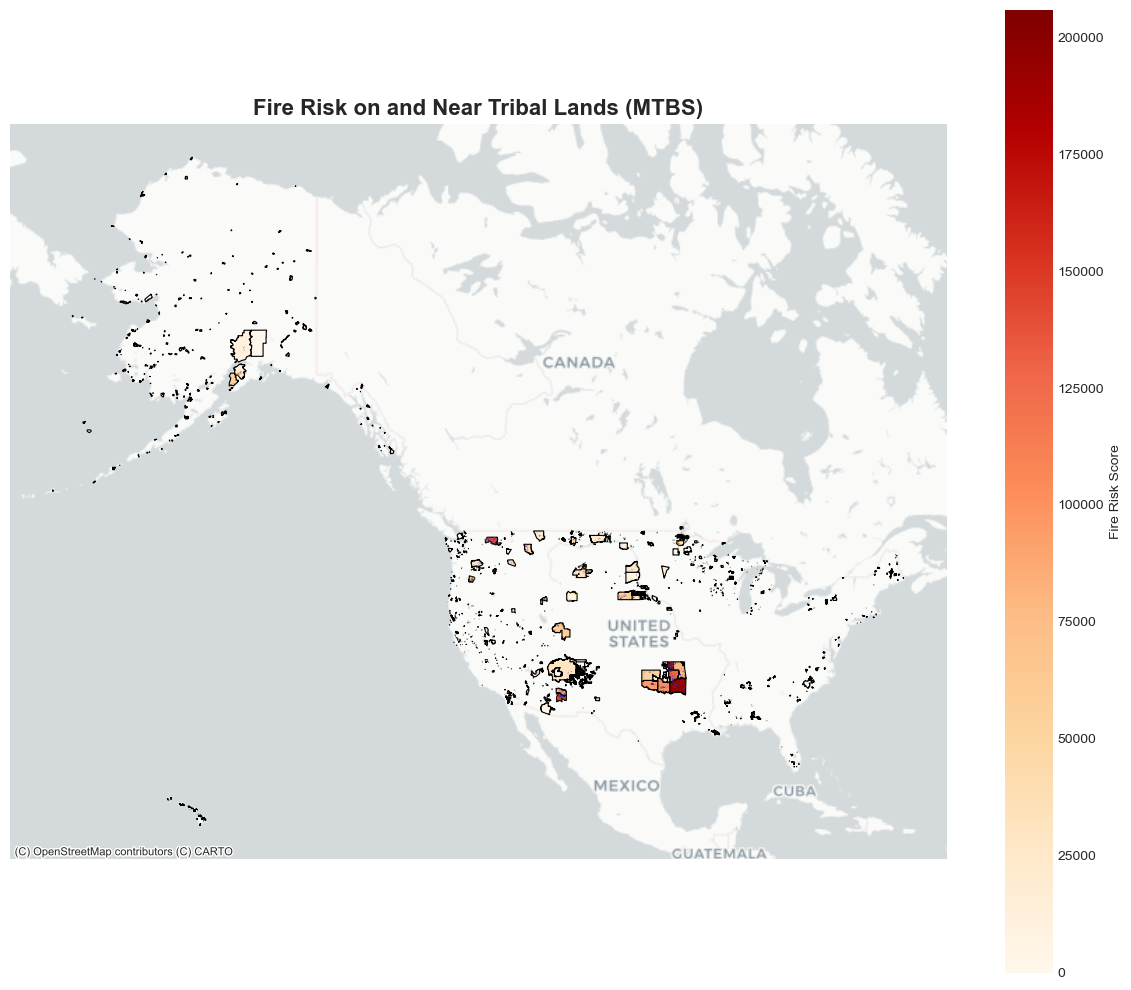

In [30]:
# Call the map function

fig = plot_fire_risk_map_static(
    fires_on_tribal=fires_on_tribal,
    fires_near_tribal=fires_near_tribal,
    tribal_lands=tribal_lands,
    tribal_risk_stats=tribal_risk_stats,
    save_path="fire_risk_map.png"
)

In [31]:
# Create a pairplot with seaborn for the results

import seaborn as sns

def create_fire_pairplot(fires_on_tribal, fires_near_tribal, top_n=10):
    """
    Create a Seaborn pairplot comparing fire metrics for top tribal lands.
    
    Parameters:
    - fires_on_tribal: GeoDataFrame of fires on tribal lands
    - fires_near_tribal: GeoDataFrame of fires near tribal lands
    - top_n: number of top tribal lands to include (by fire count)
    """
    
    # Summarize fires
    def summarize_fires(gdf, label):
        summary = gdf.groupby('NAME').agg(
            fire_count=('BurnBndAc', 'count'),
            total_acres=('BurnBndAc', 'sum'),
            avg_fire_size=('BurnBndAc', 'mean')
        ).reset_index()
        summary['Type'] = label
        return summary
    
    on_summary = summarize_fires(fires_on_tribal, 'On Tribal Lands')
    near_summary = summarize_fires(fires_near_tribal, 'Near Tribal Lands')
    
    # Combine datasets
    combined = pd.concat([on_summary, near_summary], ignore_index=True)
    
    # Keep top tribes by fire count on tribal lands
    top_tribes = on_summary.sort_values('fire_count', ascending=False).head(top_n)['NAME']
    combined = combined[combined['NAME'].isin(top_tribes)]
    
    # --- Optional: log-transform wide variables ---
    combined['log_total_acres'] = combined['total_acres'].apply(lambda x: np.log1p(x))
    combined['log_avg_fire_size'] = combined['avg_fire_size'].apply(lambda x: np.log1p(x))
    
    # Select variables for pairplot
    pairplot_cols = ['fire_count', 'log_total_acres', 'log_avg_fire_size', 'Type']
    
    # Create pairplot
    sns.set(style="whitegrid")
    g = sns.pairplot(combined[pairplot_cols], hue='Type', palette=['blue', 'orange'], diag_kind='kde')
    
    # Customize titles
    g.fig.suptitle("Pairwise Fire Metrics for Top Tribal Lands", fontsize=16, fontweight='bold', y=1.02)
    
    plt.show()

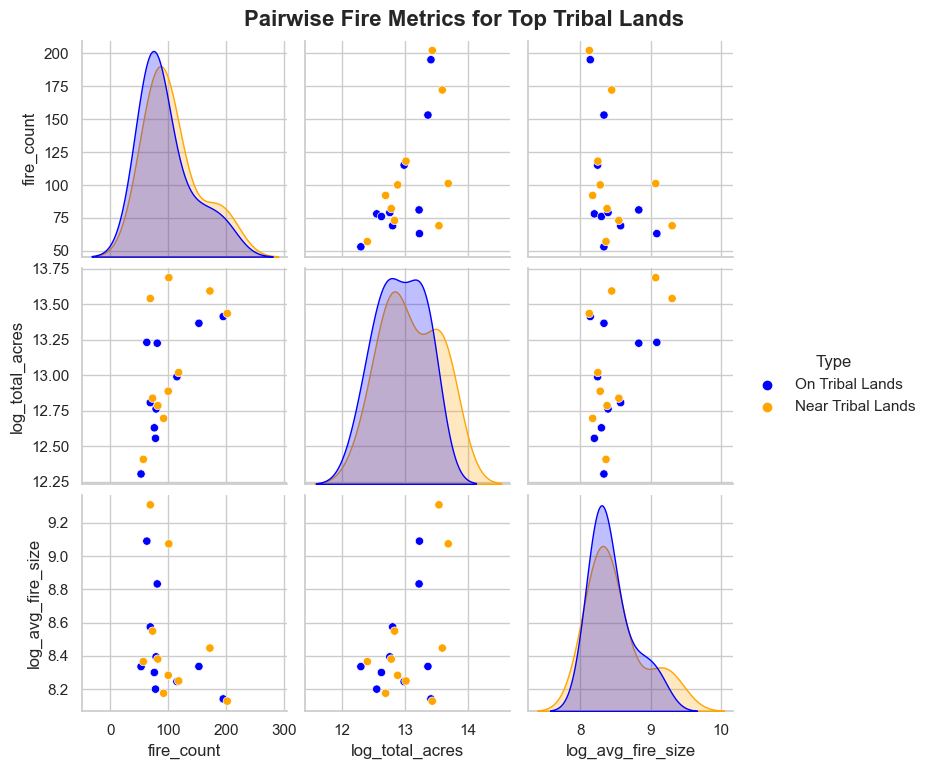

In [32]:
# Call the pairplot

create_fire_pairplot(fires_on_tribal, fires_near_tribal, top_n=10)